Podaci nisu podijeljeni na train/valid/test

In [1]:
import re
import spacy
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
nlp = spacy.load(
    "en_core_web_lg"
)
df = pd.read_csv("train_all_tasks.csv")

Svaki redak uzorka sadržava:

In [84]:
print(df.columns)

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'], dtype='object')


Broj redaka:

In [85]:
print(df.shape[0])

14000


Radimo s nebalansiranim skupom podataka

Broj redaka iz klase seksistički:

In [86]:
print(len(df[df['label_sexist'] == 'sexist']))

3398


Broj redaka iz klase neseksistički:

In [87]:
print(len(df[df['label_sexist'] == 'not sexist']))

10602


Nema Nan podataka:

In [88]:
print(df.isnull().values.any())

False


In [89]:
najvise = 0
seksisti = []
neseksisti = []
prosrijeci = [0, 0]
djelitelj = [0, 0]
for i in df.itertuples():
    doc = nlp(i.text.lower())
    najvise = max(najvise, len(doc))
    br_rijeci = len(doc)
    tret = [token.lemma_
         for token in doc
         if not token.is_stop and not token.is_punct and token.is_alpha]
    if i.label_sexist == 'sexist':
        prosrijeci[0] += br_rijeci
        djelitelj[0] += 1
        for j in tret:
            seksisti.append(j)
    else:
        prosrijeci[1] += br_rijeci
        djelitelj[1] += 1
        for j in tret:
            neseksisti.append(j)

Najčešće riječi za klasu seksisti:

In [90]:
word_freq = Counter(seksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

('woman', 1726)
('man', 729)
('like', 502)
('bitch', 498)
('fuck', 359)


Najčešće riječi za klasu ne seksisti:

In [91]:
word_freq = Counter(neseksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

('woman', 2626)
('url', 1516)
('like', 1300)
('girl', 1228)
('man', 1033)


Broj prosječnih riječi: (tokena)
[seksisti, neseksisti]

In [92]:
print(najvise)
prosrijeci[0] /= djelitelj[0]
prosrijeci[1] /= djelitelj[1]
print(prosrijeci)

86
[29.620364920541494, 27.688077721184683]


Razdvojimo na train/valid/test:

In [2]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

lista_tekst = df["text"]
lista_label = df["label_sexist"]

for train_index, test_index in sss.split(lista_tekst, lista_label):
    X_train, X_test = lista_tekst[train_index], lista_tekst[test_index]
    y_train, y_test = lista_label[train_index], lista_label[test_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_test = {"text": X_test, "label": y_test}
    df_test = pd.DataFrame(d_test)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)

lista_tekst = np.array(df_train["text"])
lista_label = np.array(df_train["label"])

for train_index, valid_index in sss.split(lista_tekst, lista_label):
    X_train, X_valid = lista_tekst[train_index], lista_tekst[valid_index]
    y_train, y_valid = lista_label[train_index], lista_label[valid_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_valid = {"text": X_valid, "label": y_valid}
    df_valid = pd.DataFrame(d_valid)

print(len(df_test), len(df_valid), len(df_train))


2800 1400 9800


Pogledajmo [URL], [USER], emoji:

Za [URL]:

In [94]:
urlovi = [0, 0]
sexist_c = len(df_train[df_train['label'] == 'sexist'])
nsexist_c = len(df_train[df_train['label'] == 'not sexist'])
for i in df_train.itertuples():
    kolko = i.text.count("[URL]")
    if i.label == 'sexist':
        urlovi[0] += kolko
    else:
        urlovi[1] += kolko
print(urlovi)
print(urlovi[0] / sexist_c, urlovi[0] / nsexist_c)

[141, 1081]
0.059293523969722456 0.018997574777687955


Za [USER]:

In [95]:
useri = [0, 0]
for i in df_train.itertuples():
    kolko = i.text.count("[USER]")
    if i.label == 'sexist':
        useri[0] += kolko
    else:
        useri[1] += kolko
print(useri)
print(useri[0] / sexist_c, useri[1] / nsexist_c)

[104, 567]
0.04373423044575273 0.07639450282942603


Za emoji:

In [96]:
import re
a_list = ['🤔 🙈 me así, bla es se 😌 ds 💕👭👙']
re.findall(r'[^\w\s,]', a_list[0])

['🤔', '🙈', '😌', '💕', '👭', '👙']

In [97]:
emojiji = [0, 0]
for i in df_train.itertuples():
    doc = nlp(i.text)
    kolko = len(re.findall(r'[^\w\s,]', str(doc)[0]))
    if i.label == 'sexist':
        emojiji[0] += kolko
    else:
        emojiji[1] += kolko
print(emojiji)
print(emojiji[0] / sexist_c, emojiji[1] / nsexist_c)

[118, 614]
0.0496215306980656 0.08272702775532202


SVM + WORD2VEC

In [4]:
from gensim.models import KeyedVectors
from gensim import models
from gensim.utils import simple_preprocess

word2vec_path = './word2vec_pretrained/GoogleNews-vectors-negative300.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)



In [ ]:
model.most_similar(positive=["man"])


[('guy', 0.46131259202957153),
 ('woman', 0.4579407870769501),
 ('person', 0.4177495837211609),
 ('shot', 0.3957900106906891),
 ('slut', 0.39145252108573914),
 ('relationship', 0.3715061545372009),
 ('husband', 0.3656804859638214),
 ('strong', 0.35737934708595276),
 ('joke', 0.3455785810947418),
 ('simp', 0.34193453192710876)]

In [6]:
def W2Vvectorize(train):
    corpus_text = '\n'.join(train)
    sentences = corpus_text.split('\n')
    sentences = [line.lower().split(' ') for line in sentences]

    def clean(s):
        return [w.strip(',."!?:;()\'') for w in s]

    sentences = [clean(s) for s in sentences if len(s) > 0]
    vector=[]
    for sent in sentences:
        sent_vec=np.zeros(300)
        count =0
        for word in sent: 
            if word in model:
                vec = model[word]
                sent_vec += vec 
                count += 1
        if count != 0:
            sent_vec /= count #normalize
        vector.append(sent_vec)
    return vector

In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

lista_label = np.array(df_valid["label"])
lista_label = le.fit_transform(lista_label)

nova_lista = W2Vvectorize(df_valid["text"])

In [10]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(nova_lista, lista_label)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.757 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [11]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)


In [13]:
import sklearn.metrics

lista_label_test = np.array(df_test["label"])
lista_label_test = le.fit_transform(lista_label_test)
nova_lista_test = W2Vvectorize(df_test["text"])

grid_predictions = grid.predict(nova_lista_test)

# print classification report
print(sklearn.metrics.classification_report(lista_label_test, grid_predictions))


              precision    recall  f1-score   support

           0       0.78      0.99      0.87      2120
           1       0.79      0.11      0.19       680

    accuracy                           0.78      2800
   macro avg       0.78      0.55      0.53      2800
weighted avg       0.78      0.78      0.70      2800



In [15]:
lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

nova_lista = W2Vvectorize(df_train["text"])

clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', C=10, gamma=0.01))
clf = clf.fit(nova_lista, lista_label)


In [8]:
print("Training:"+str(clf.score(nova_lista, lista_label)))

lista_label_test = np.array(df_test["label"])
lista_label_test = le.fit_transform(lista_label_test)
nova_lista_test = W2Vvectorize(df_test["text"])

print("Test:"+str(clf.score(nova_lista_test,lista_label_test)))


Training:0.8760204081632653
Test:0.8039285714285714


In [16]:
def evaluate(model, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = W2Vvectorize(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.81      0.96      0.88      2120
      sexist       0.69      0.31      0.43       680

    accuracy                           0.80      2800
   macro avg       0.75      0.63      0.65      2800
weighted avg       0.78      0.80      0.77      2800

Precision:   0.80
   Recall:   0.80
       F1:   0.80


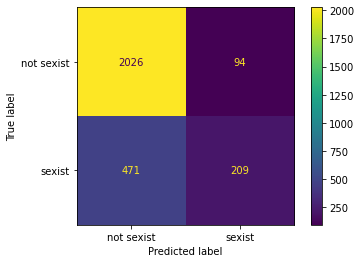

In [17]:
evaluate(clf, df_test.text, lista_label_test)

In [18]:
import pickle
word2vec_clf = pickle.dumps(clf)

SVM +TF_IDF

In [60]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_train["text"]
vectorizer = TfidfVectorizer()
le = LabelEncoder()

lista_label = np.array(df_valid["label"])
lista_label = le.fit_transform(lista_label)
nova_lista = vectorizer.fit_transform(df_valid["text"])

In [63]:
# from sklearn.feature_extraction.text import CountVectorizer
# import sklearn.pipeline

# pipeline = sklearn.pipeline.Pipeline([
#            ('vect', TfidfVectorizer()),
#            ('clf', SVC()),
# ])

# parameters = [{
#     'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (None, 5000, 10000, 50000),
#     'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2', None),
#     'clf__max_iter': (20,),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
#     'clf__max_iter': (10, 50, 80)},
# 	{
#     'vect': (CountVectorizer(),)
#     # count_vect_params...
#     'clf__max_iter': (20,),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
#     'clf__max_iter': (10, 50, 80)
# }]

# grid_search = GridSearchCV(pipeline, parameters)

# # fitting the model for grid search
# grid.fit(nova_lista, lista_label)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (Temp/ipykernel_172/743078897.py, line 19)

In [29]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)


In [43]:
corpus = df_train["text"]
X = vectorizer.fit_transform(corpus)


In [52]:
lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

clf = make_pipeline(SVC(class_weight='balanced', C=10, gamma=0.1))
clf = clf.fit(X, lista_label)


In [53]:
print("Training:"+str(clf.score(X, lista_label)))

lista_label_test = np.array(df_test["label"])
lista_label_test = le.transform(lista_label_test)
nova_lista_test = vectorizer.transform(df_test["text"])

print("Test:"+str(clf.score(nova_lista_test,lista_label_test)))

Training:0.9673469387755103
Test:0.7882142857142858


In [54]:
def evaluate(model, tf_idf, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = tf_idf.transform(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.87      0.85      0.86      2120
      sexist       0.56      0.61      0.58       680

    accuracy                           0.79      2800
   macro avg       0.71      0.73      0.72      2800
weighted avg       0.79      0.79      0.79      2800

Precision:   0.79
   Recall:   0.79
       F1:   0.79


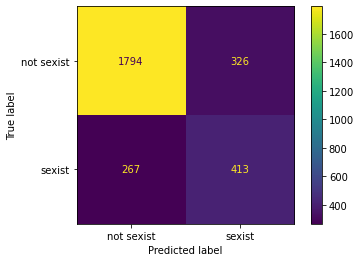

In [55]:
evaluate(clf, vectorizer, df_test.text, lista_label_test)

In [56]:
import pickle
tfidf_clf = pickle.dumps(clf)

In [25]:
load_w2v_clf = pickle.loads(word2vec_clf)
tekst = "woman is nothing"
tekst_v = W2Vvectorize(tekst)
if round(np.mean(load_w2v_clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

not sexist


In [59]:
load_tfidf_clf = pickle.loads(tfidf_clf)
tekst = "you are nice"
tekst_v = vectorizer.transform([tekst])
if round(np.mean(load_tfidf_clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

not sexist
